<a href="https://colab.research.google.com/github/lapshinaaa/homework_DeepLearning/blob/main/Lapshina_HW3_ts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 3: прогнозирование временных рядов</center></h2>

**Мягкий дедлайн:** 23:59MSK 19.05.2024

**Жесткий дедлайн:** 23:59MSK 26.05.2024

In [ ]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.2/422.2 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.1/354.1 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 91.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 101.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 100.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 78.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

In [ ]:
import warnings
import gdown
import pandas as pd
import numpy as np
from copy import deepcopy

warnings.filterwarnings("ignore")

В данной задаче мы будем решать одну из актуальных практических задач, с которыми, в том числе, сталкиваются разработчики ETNA - прогнозирование объема необходимой наличности в банкоматах. Пожалуй, ни для кого не секрет, что отсутствие необходимой суммы в банкомате не делает клиента банка счастливее. В то же время, избыток заправленной в банкомат наличности приводит к упущенной выгоде - ведь, в конечном счете, эти деньги могли быть размещены в качестве краткосрочного депозита на межбанковском рынке. Для кредитной организации с обширной сетью банкоматов даже незначительное улучшение качества предсказания способно внести значительный вклад в прибыльность этой ветки бизнеса.

В качестве инструмента воспользуемся библиотекой ETNA, документацию можно прочитать [тут](https://docs.etna.ai/stable/), и [чат](https://t.me/etna_support) комьюнити.

Мы будем использовать дневные данные реальных банкоматов для чего возьмем мультисегментный датасет.

In [ ]:
url = 'https://gist.githubusercontent.com/Polzovat123/4d6d5e544e93429c2d3db29196e9c918/raw/24b27e60f587128d71678e267f51cd48472c6a84/atms_daily_cash.csv'
output = 'atms_daily_cash.csv'
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

df = pd.read_csv('atms_daily_cash.csv', index_col=False)

Downloading...
From: https://gist.githubusercontent.com/Polzovat123/4d6d5e544e93429c2d3db29196e9c918/raw/24b27e60f587128d71678e267f51cd48472c6a84/atms_daily_cash.csv
To: /content/atms_daily_cash.csv
100%|██████████| 258k/258k [00:00<00:00, 8.90MB/s]


Полученные данные были просуммированы по банкоматам и дням эксплуатации, после чего залиты в gist, откуда мы и берем их.

Взглянем на то, что представляют из себя данные после этих действий:

In [ ]:
df.head()

datetime  atm_id  operation_value
0  2017-08-16      74         2.059266
1  2017-08-17      74         1.029633
2  2017-08-18      74         0.686422
3  2017-08-19      74        33.301267
4  2017-08-20      74       -12.237921

In [ ]:
df.rename(columns={'datetime': 'timestamp', 'operation_value': 'target', 'atm_id': 'segment'}, inplace=True)
df.head()

timestamp  segment     target
0  2017-08-16       74   2.059266
1  2017-08-17       74   1.029633
2  2017-08-18       74   0.686422
3  2017-08-19       74  33.301267
4  2017-08-20       74 -12.237921

In [ ]:
df['segment'].unique()

array([ 74,  85,  86,  87,  88,  90,  91,  93,  94,  96,  97,  98,  99,
       100, 101, 102, 103, 104, 105, 106])

### Задание 1. EDA (1.75 балл)

Проведите разведывательный анализ данных с помощью `ETNA`- постройте графики, на которых можно судить о наличии тренда, сезонности и прочих зависимостей. Проанализируйте корреляции. Какие выводы вы можете сделать?

Ссылку на туториал по EDA можно найти [тут](https://docs.etna.ai/stable/tutorials/103-EDA.html#EDA).

In [ ]:
from etna.datasets import TSDataset

In [ ]:
from etna.analysis import acf_plot
from etna.analysis import cross_corr_plot
from etna.analysis import distribution_plot
from etna.analysis import plot_correlation_matrix

In [ ]:
# create data structure TSDataset
ts = TSDataset(df, freq="D") # D as in "daily" because we have data for several consecutive days
ts.head(5)

segment       100    101    102    103    104    105    106     74     85  \
feature    target target target target target target target target target   
timestamp                                                                   
2017-06-09    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-06-10    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-06-11    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-06-12    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-06-13    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

segment        86         87     88     90     91     93     94     96     97  \
feature    target     target target target target target target target target   
timestamp                                                                       
2017-06-09    NaN   0.617780    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-06-10    NaN   1.441486    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-06-11    NaN  -0.235345    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-06-12    NaN -13.532317    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-06-13    NaN   7.398647    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

segment        98     99  
feature    target target  
timestamp                 
2017-06-09    NaN    NaN  
2017-06-10    NaN    NaN  
2017-06-11    NaN    NaN  
2017-06-12    NaN    NaN  
2017-06-13    NaN    NaN

In [ ]:
ts.describe()

start_timestamp end_timestamp  length  num_missing  num_segments  \
segments                                                                    
100           2017-08-11    2018-09-30     416            3            20   
101           2017-08-11    2018-09-30     416            3            20   
102           2017-08-02    2018-09-30     425            3            20   
103           2017-08-08    2018-09-30     419            3            20   
104           2017-08-07    2018-09-30     420            3            20   
105           2017-07-28    2018-09-30     430            3            20   
106           2017-08-09    2018-09-30     418            3            20   
74            2017-08-16    2018-09-30     411            3            20   
85            2017-08-03    2018-09-30     424            3            20   
86            2017-08-01    2018-09-30     426            3            20   
87            2017-06-09    2018-09-30     479            3            20   
88            2017-08-14    2018-09-30     413            3            20   
90            2017-07-27    2018-09-30     431            3            20   
91            2017-07-19    2018-09-30     439            3            20   
93            2017-08-12    2018-09-30     415            3            20   
94            2017-08-10    2018-09-30     417            3            20   
96            2017-07-28    2018-09-30     430            3            20   
97            2017-08-16    2018-09-30     411            3            20   
98            2017-08-17    2018-09-30     410            3            20   
99            2017-08-16    2018-09-30     411            3            20   

          num_exogs  num_regressors  num_known_future freq  
segments                                                    
100               0               0                 0    D  
101               0               0                 0    D  
102               0               0                 0    D  
103               0               0                 0    D  
104               0               0                 0    D  
105               0               0                 0    D  
106               0               0                 0    D  
74                0               0                 0    D  
85                0               0                 0    D  
86                0               0                 0    D  
87                0               0                 0    D  
88                0               0                 0    D  
90                0               0                 0    D  
91                0               0                 0    D  
93                0               0                 0    D  
94                0               0                 0    D  
96                0               0                 0    D  
97                0               0                 0    D  
98                0               0                 0    D  
99                0               0                 0    D

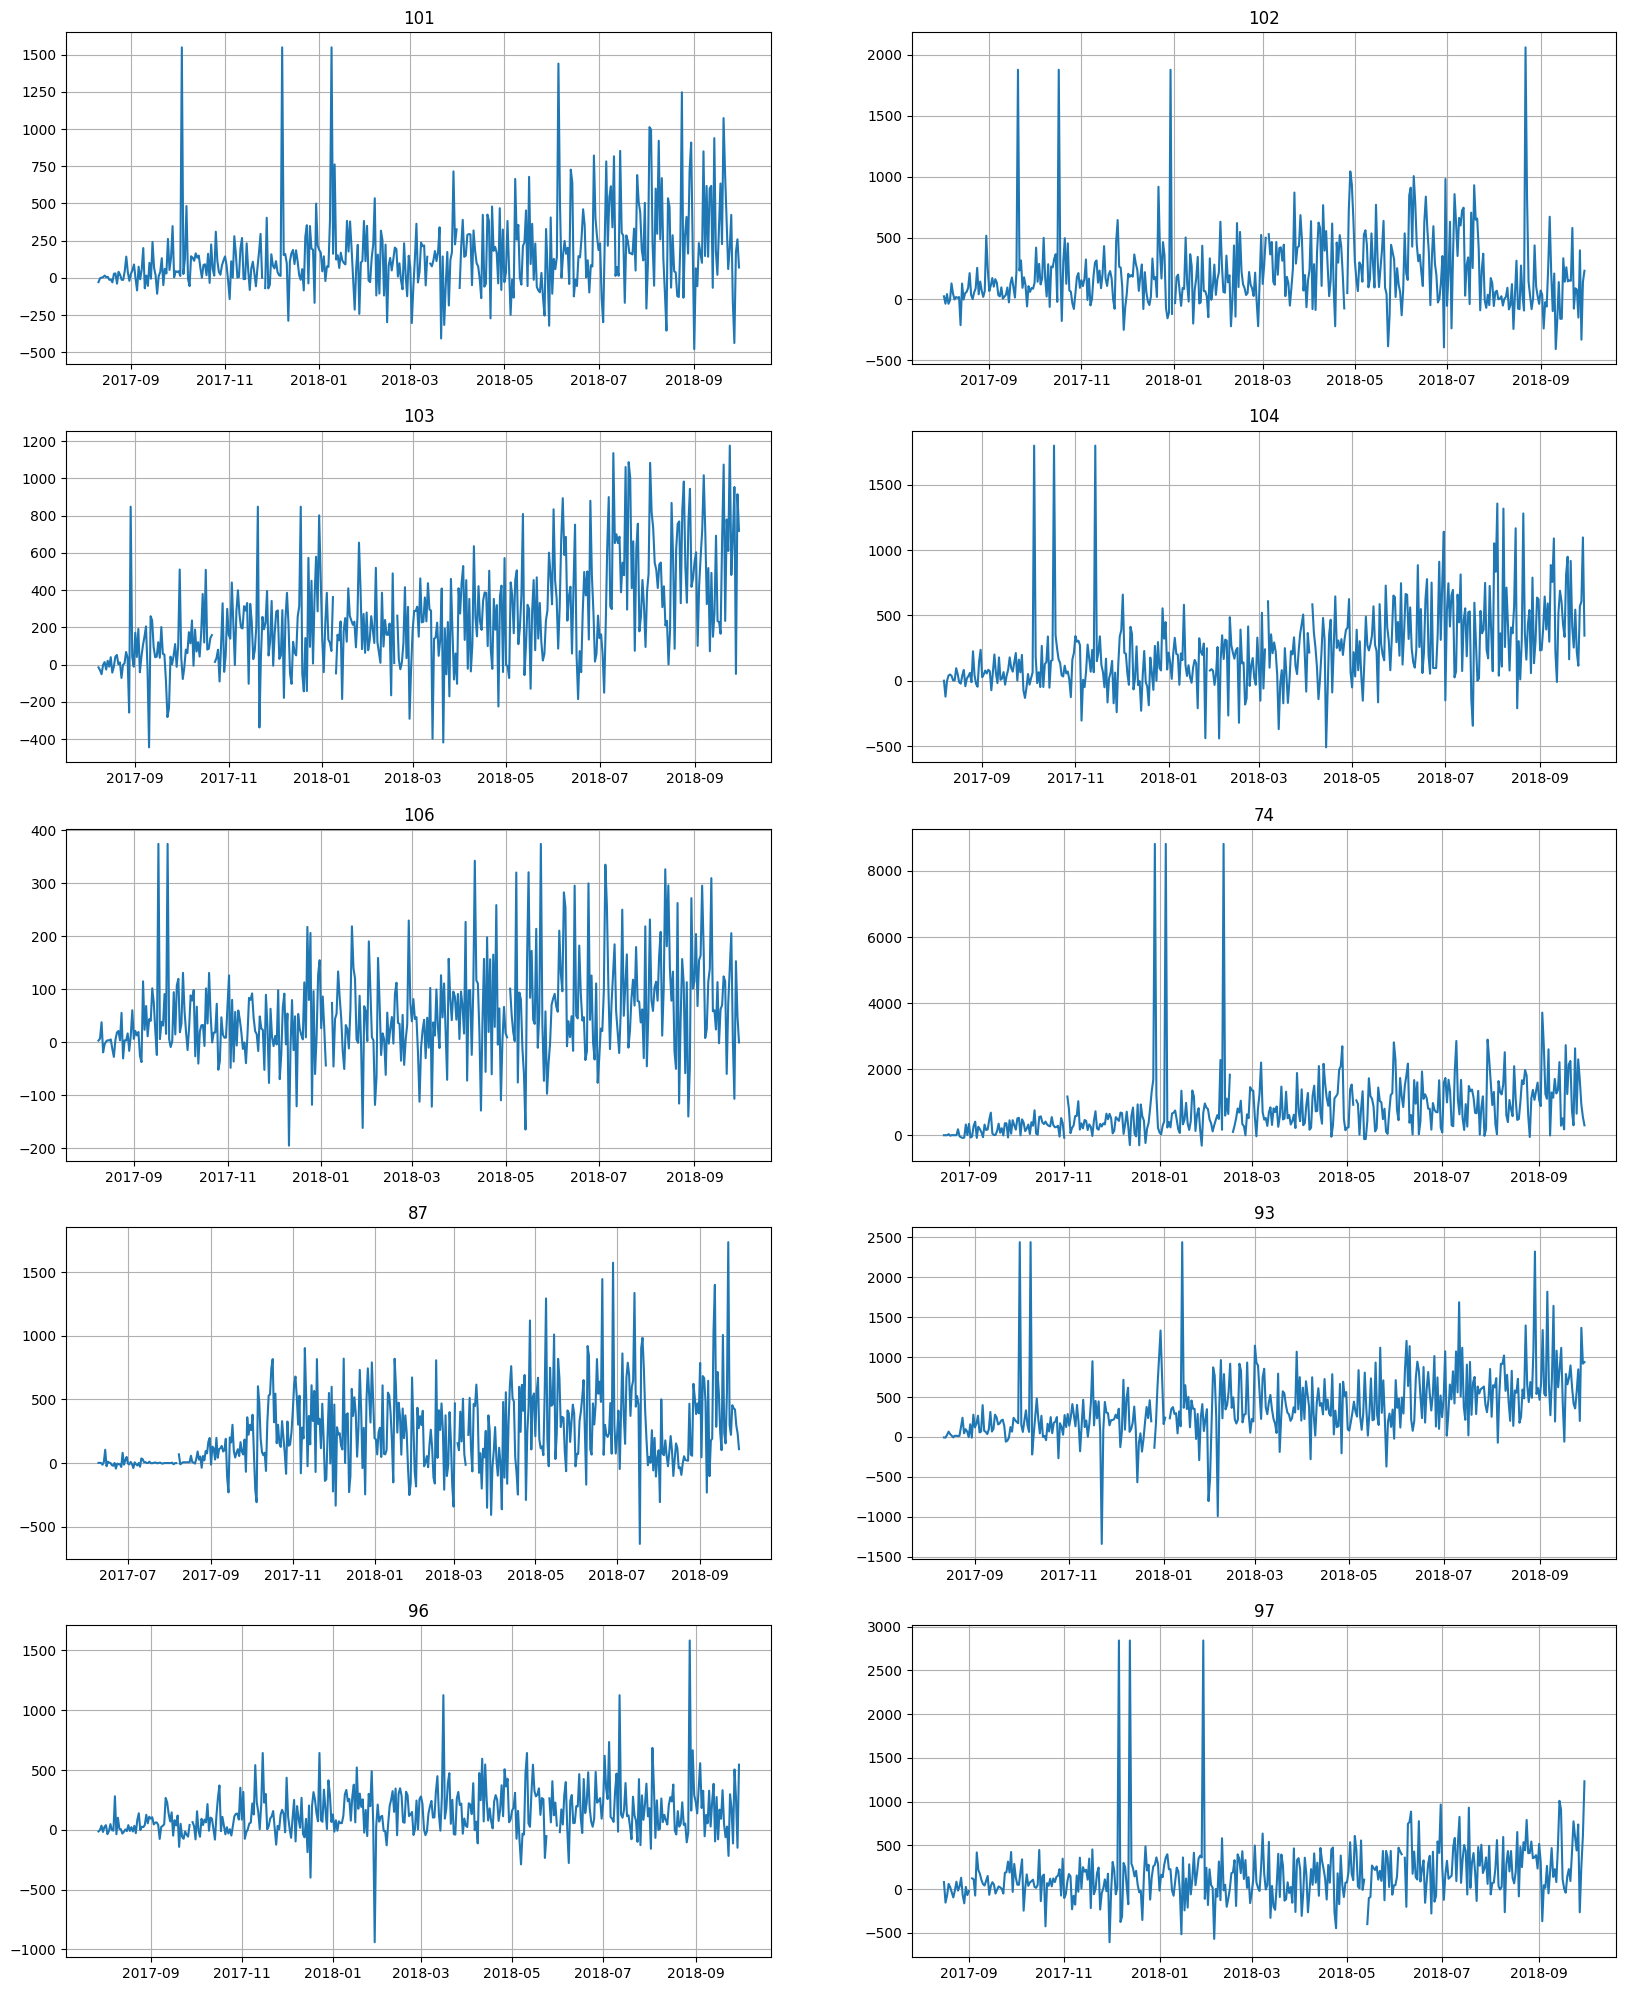

In [ ]:
ts.plot()

# Autocorrelation

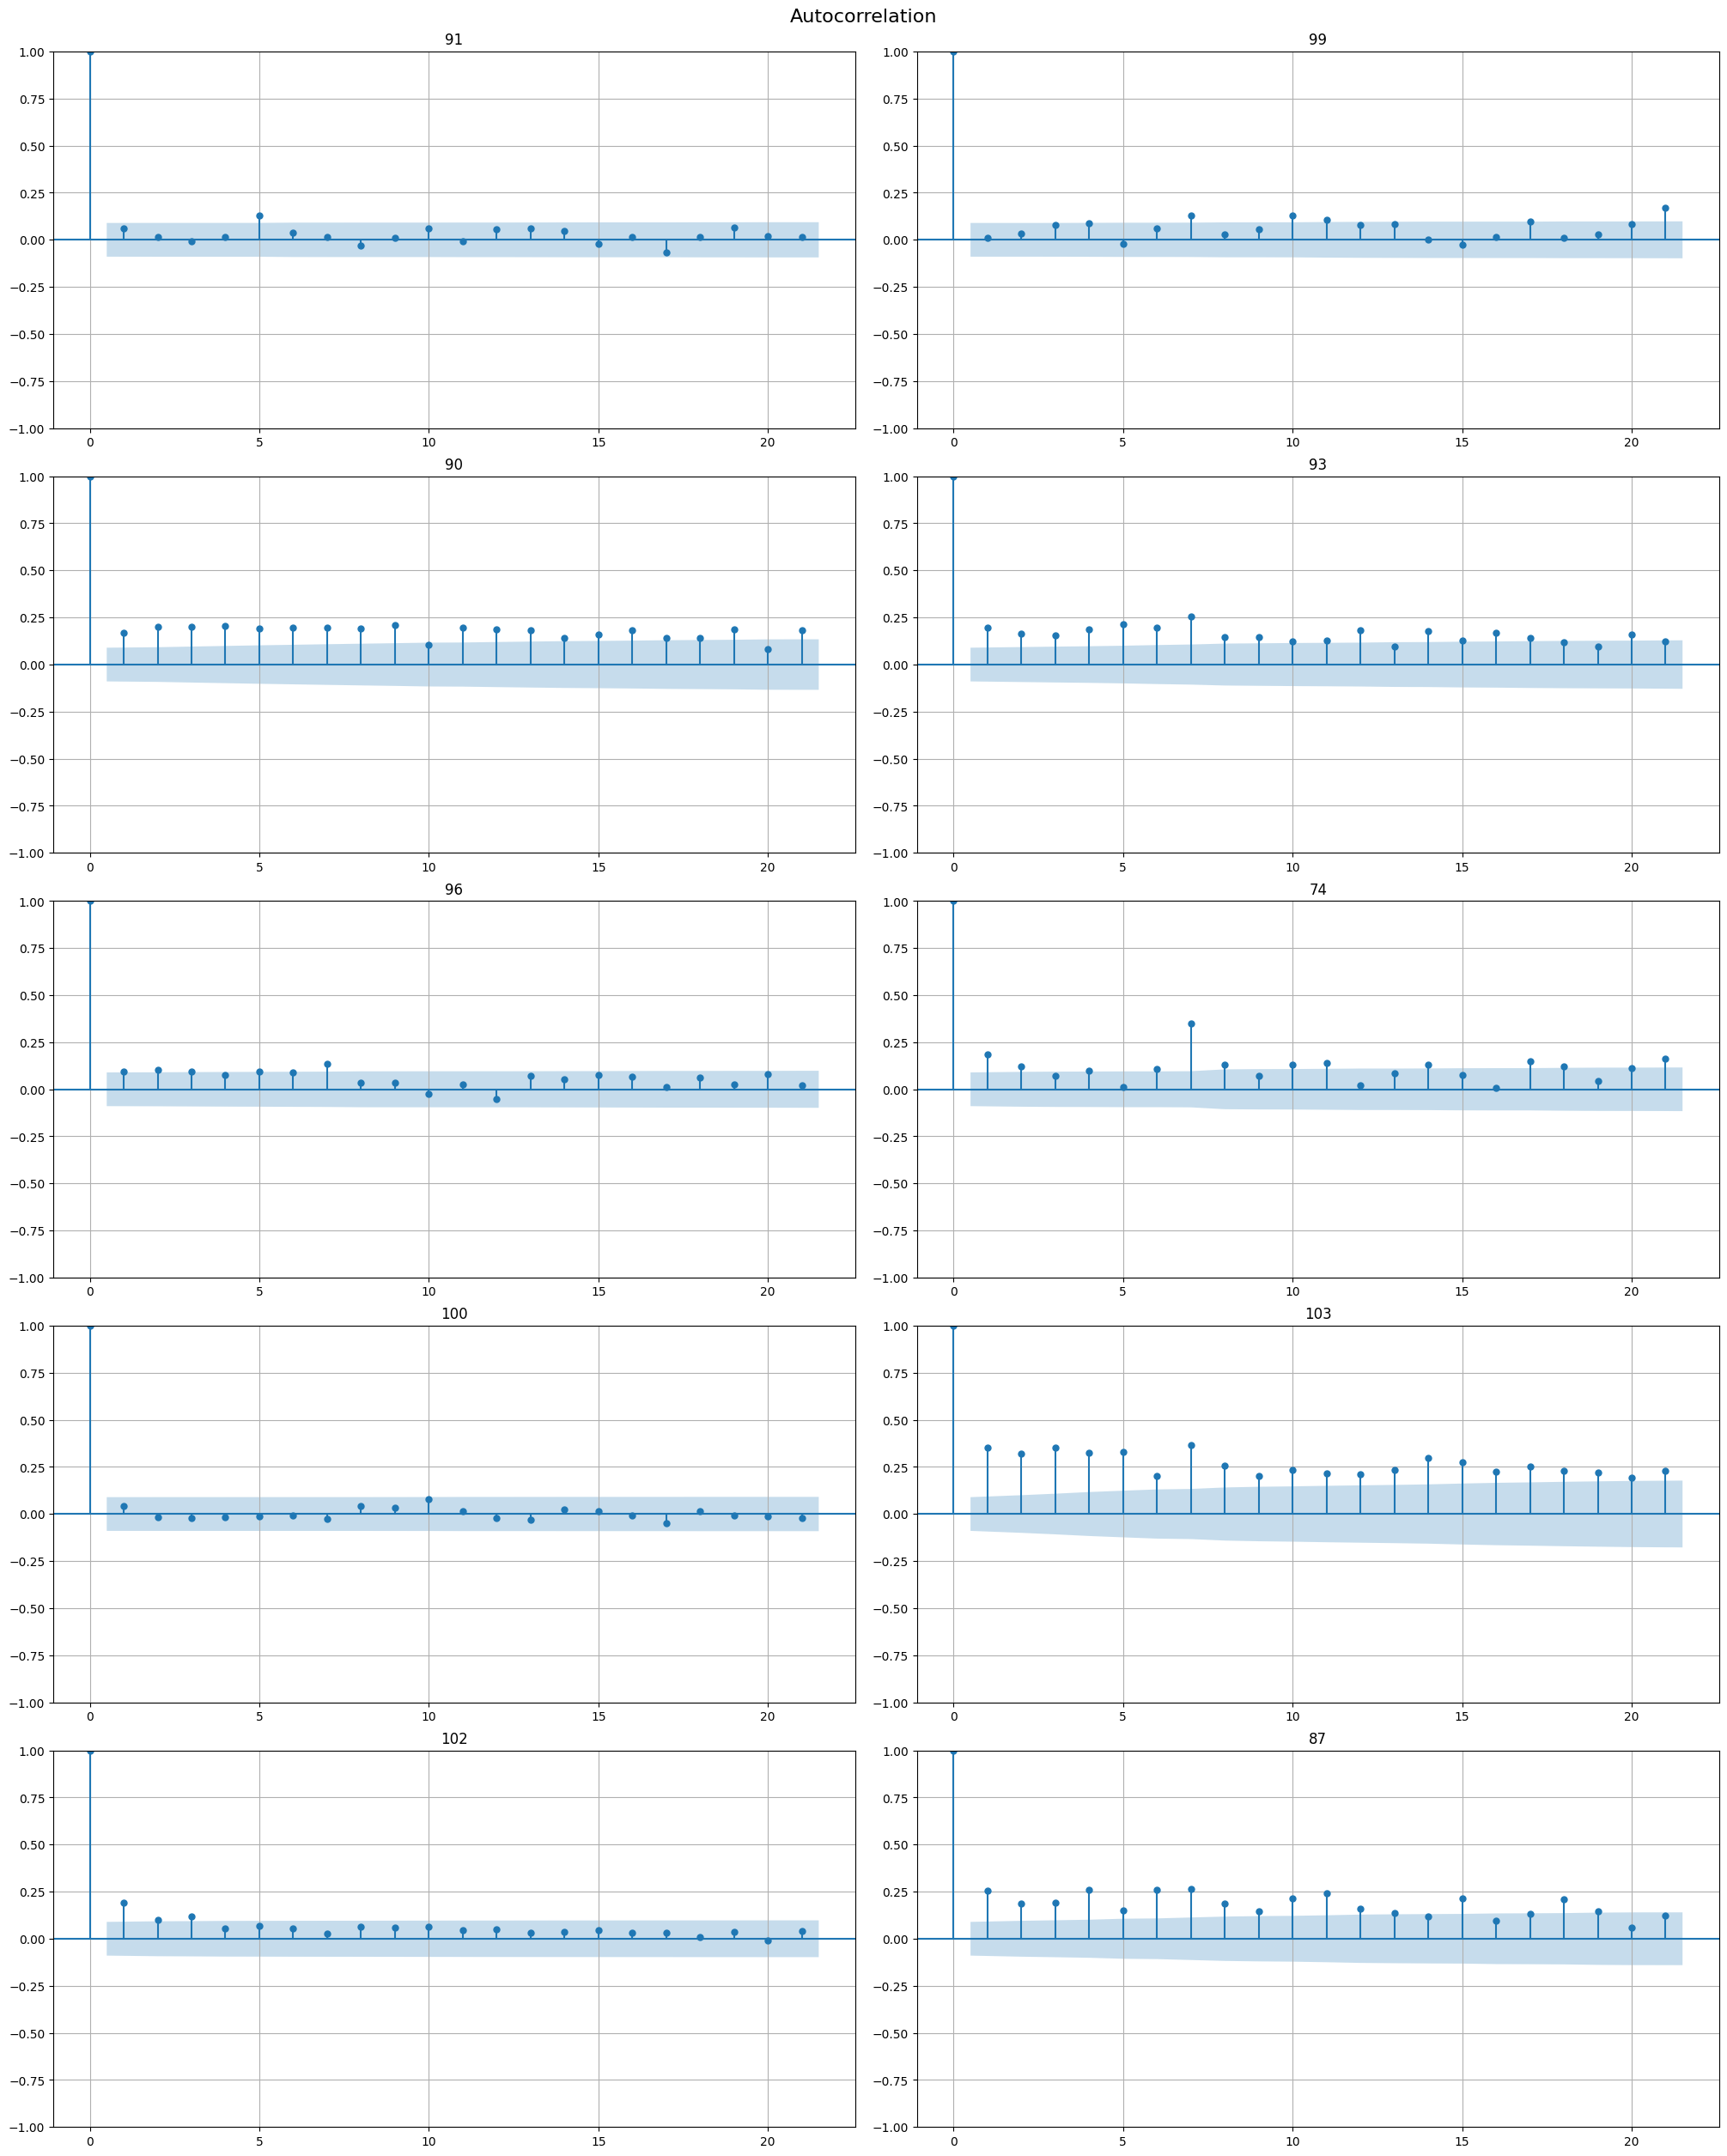

In [ ]:
acf_plot(ts, lags=21)

In the displayed graph, it's evident that the autocorrelation between the predicted value and its lag remains consistently stable. This indicates that the observed value exhibits an equal level of dependence on both distant and immediate lags, without a diminishing trend in dependence over time.

# Correlation heatmap

In [ ]:
from etna.transforms import LagTransform
from etna.transforms import LinearTrendTransform

The correlation map will be plotted for 4 segments: 74 and 103, and then 102 and 103. The other ones can be plotted as well, if need be.

In [ ]:
lags = LagTransform(in_column="target", lags=[1, 7], out_column="lag")
ts.fit_transform([lags])

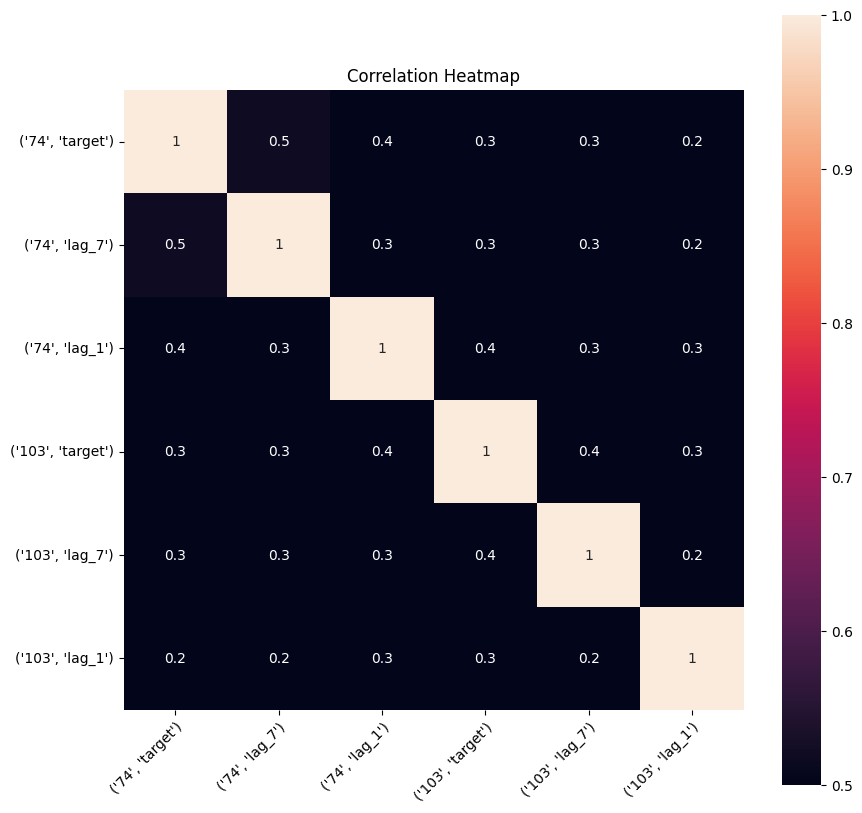

In [ ]:
plot_correlation_matrix(ts, segments=["74", "103"], method="spearman", vmin=0.5, vmax=1)

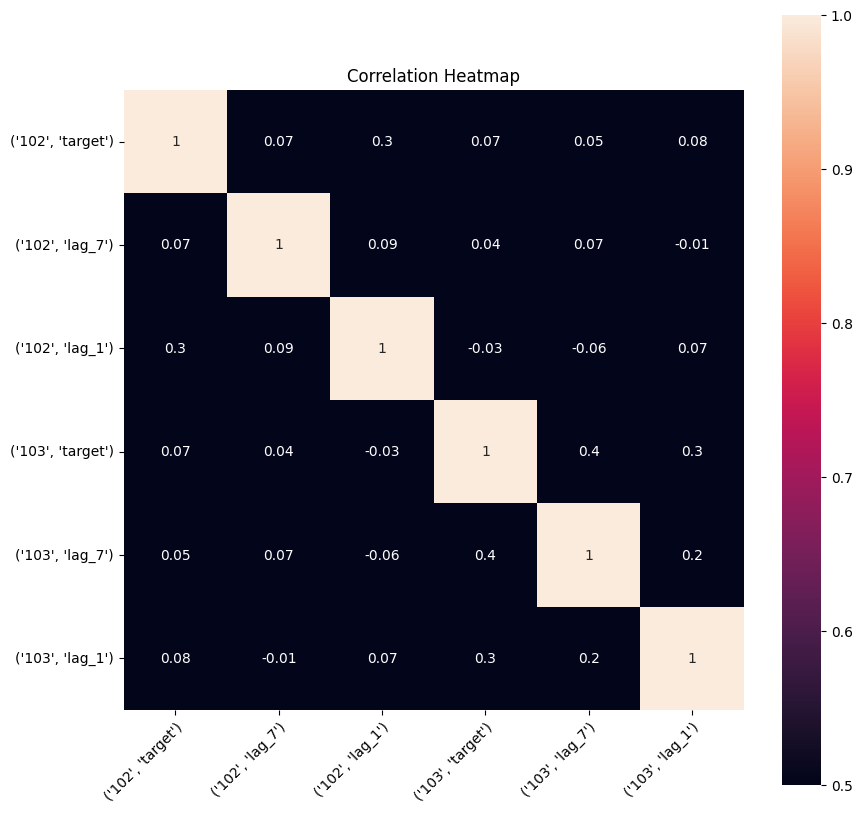

In [ ]:
plot_correlation_matrix(ts, segments=["102", "103"], method="spearman", vmin=0.5, vmax=1)

The main purpose of the heatmap is as follows, I quote: "Correlation heatmap is a visualization of pairwise correlation matrix between timeseries in a dataset. It is a simple visual tool which you may use to determine the correlated timeseries in your dataset." [https://docs.etna.ai/stable/tutorials/103-EDA.html#EDA]

It's quite noticable that there's `little to no correlation` between the presented timeseries. Same is true for the other ones.

# Trend

In [ ]:
from etna.analysis import plot_trend

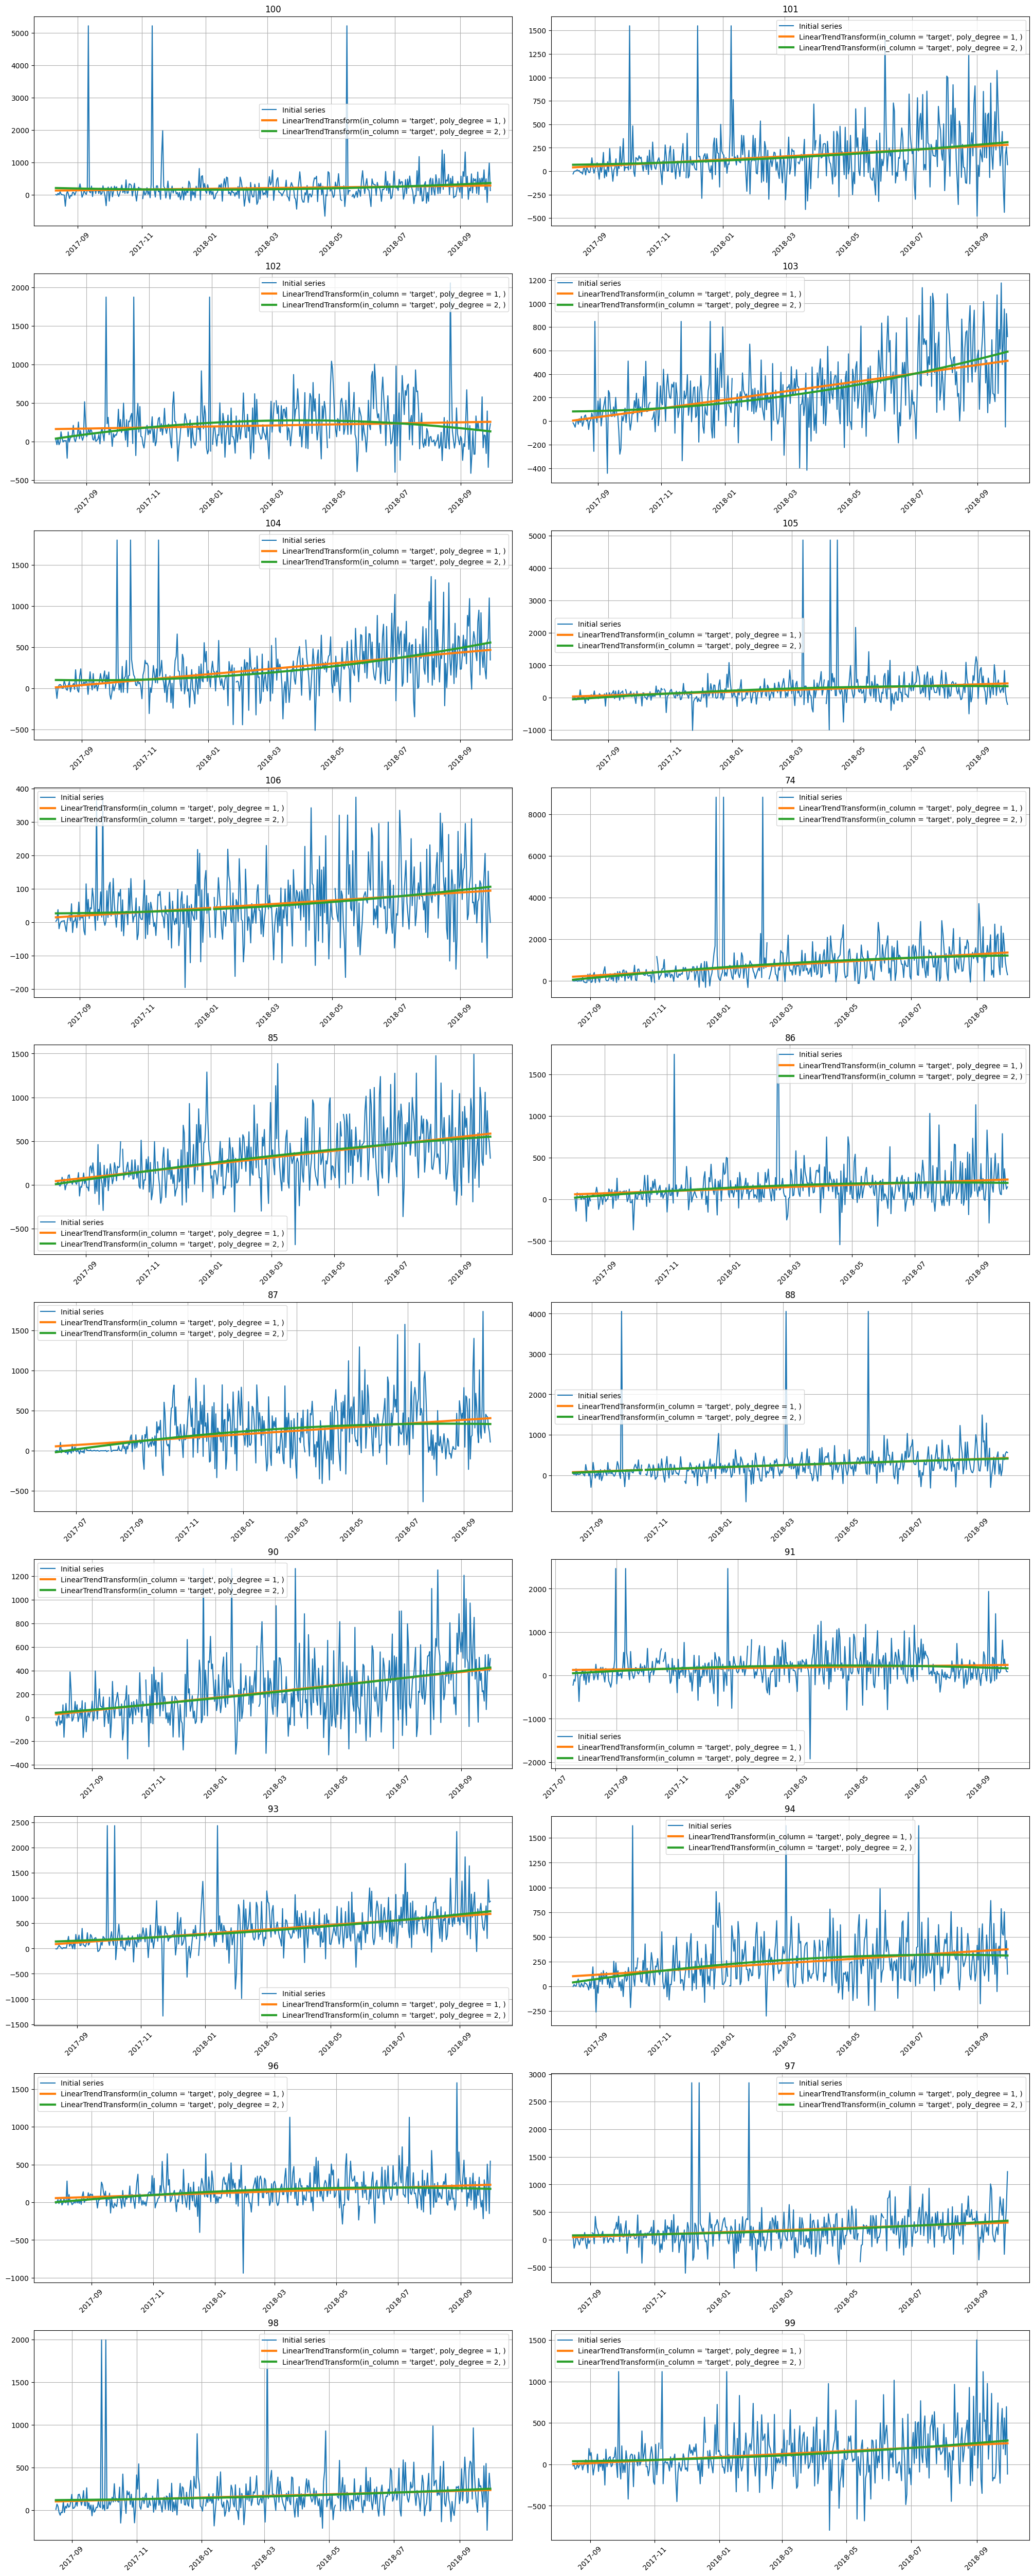

In [ ]:
# plot linear and parabolic trends
trends = [
    LinearTrendTransform(in_column="target", poly_degree=1),
    LinearTrendTransform(in_column="target", poly_degree=2),
]

plot_trend(ts, trend_transform=trends)

# Seasonality

In [ ]:
from etna.analysis import seasonal_plot

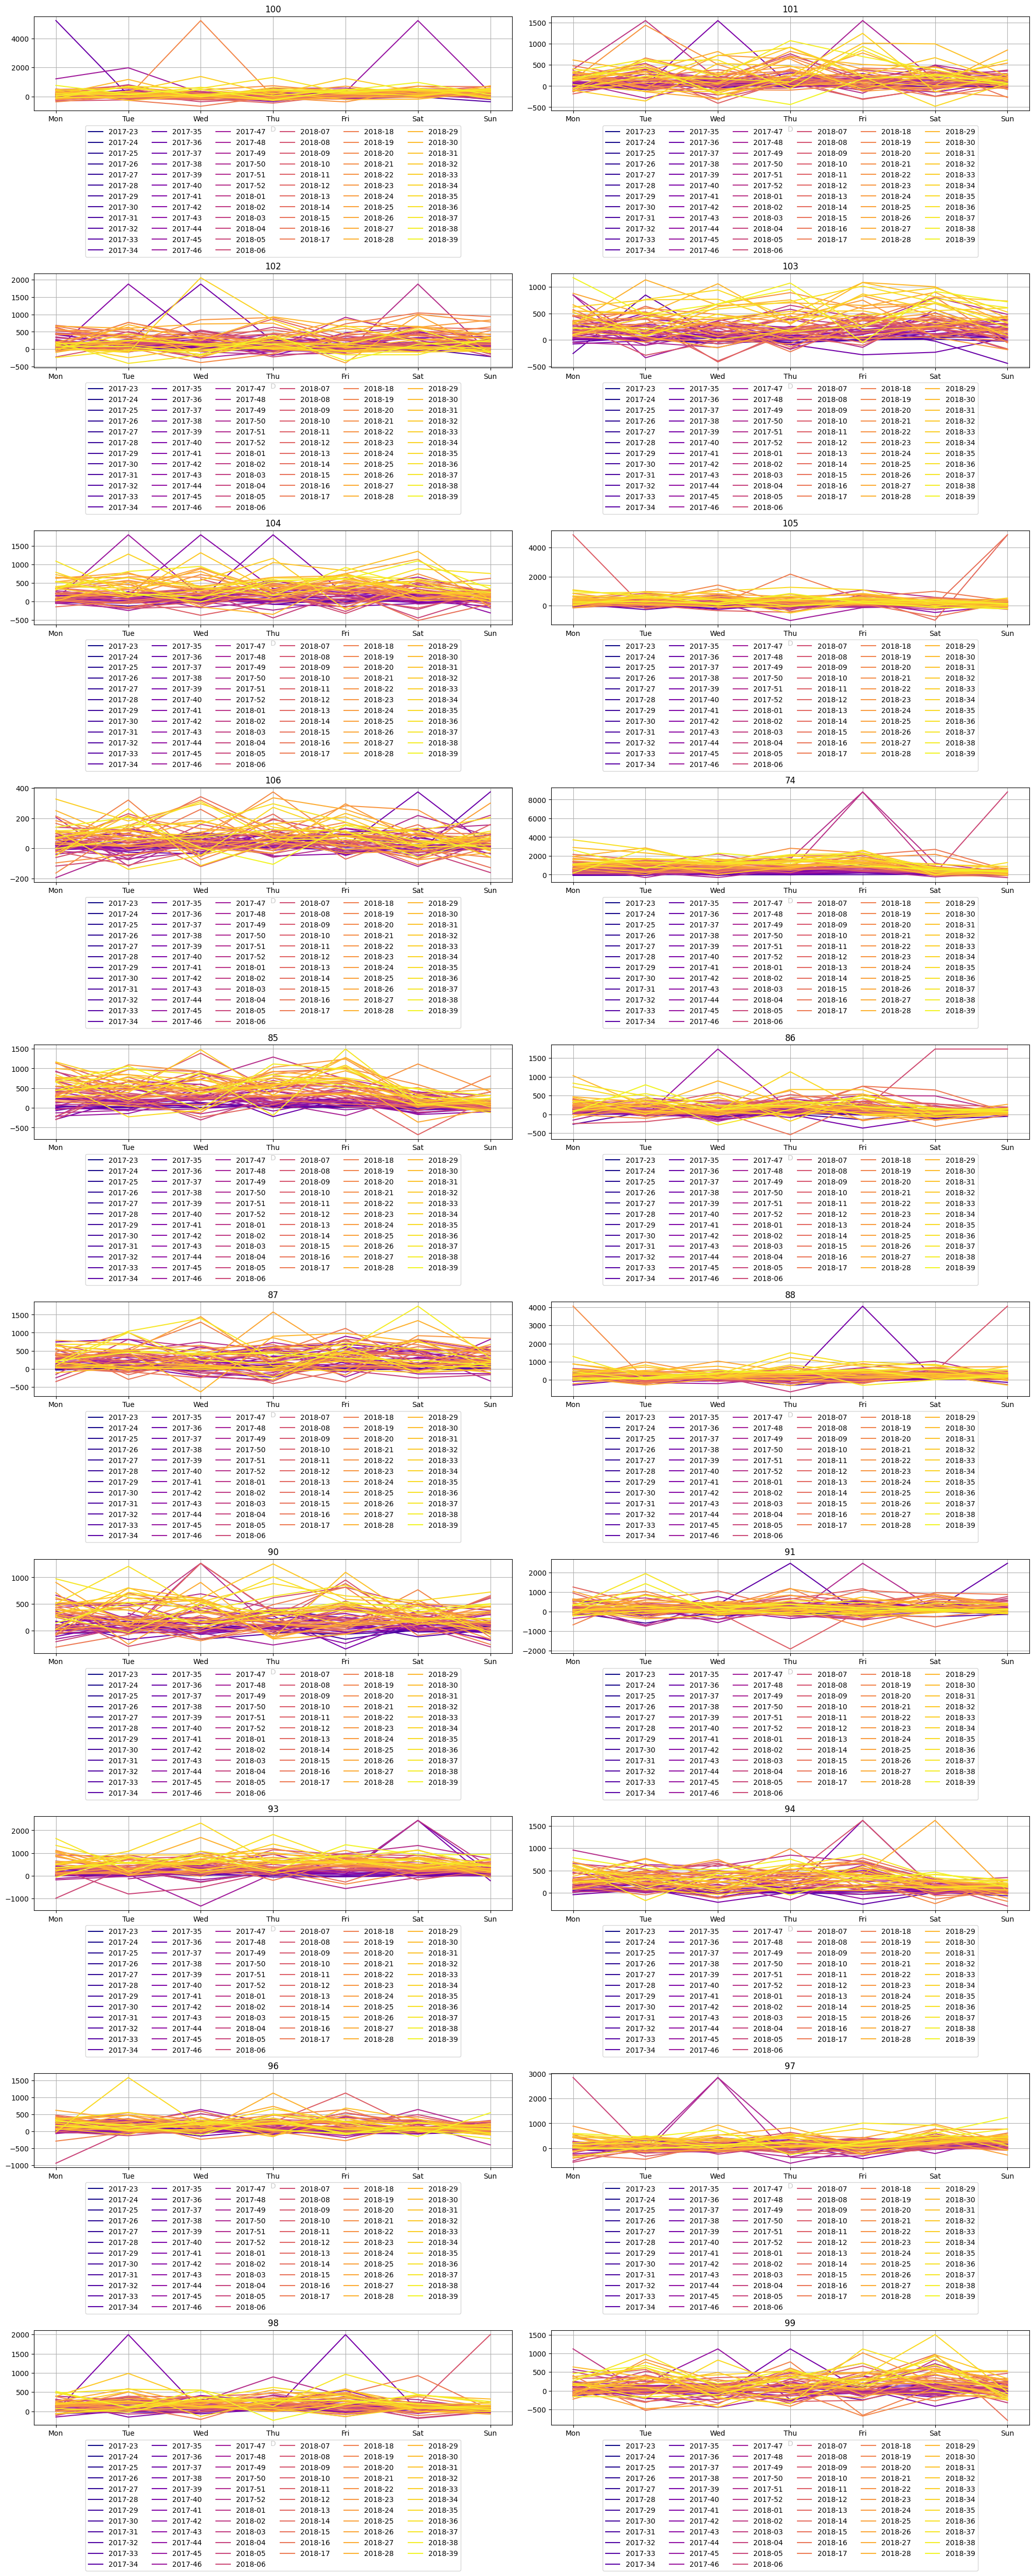

In [ ]:
seasonal_plot(ts=ts, cycle='week')

Quite interestingly, the amount of cash in the majority of the presented ATMs is highest on Wednesday, Tuesday and Friday. Indeed, according to [https://wps-feb.ugent.be/Papers/wp_13_865.pdf], the highest cash demand is usually observed during weekdays (not weekends).

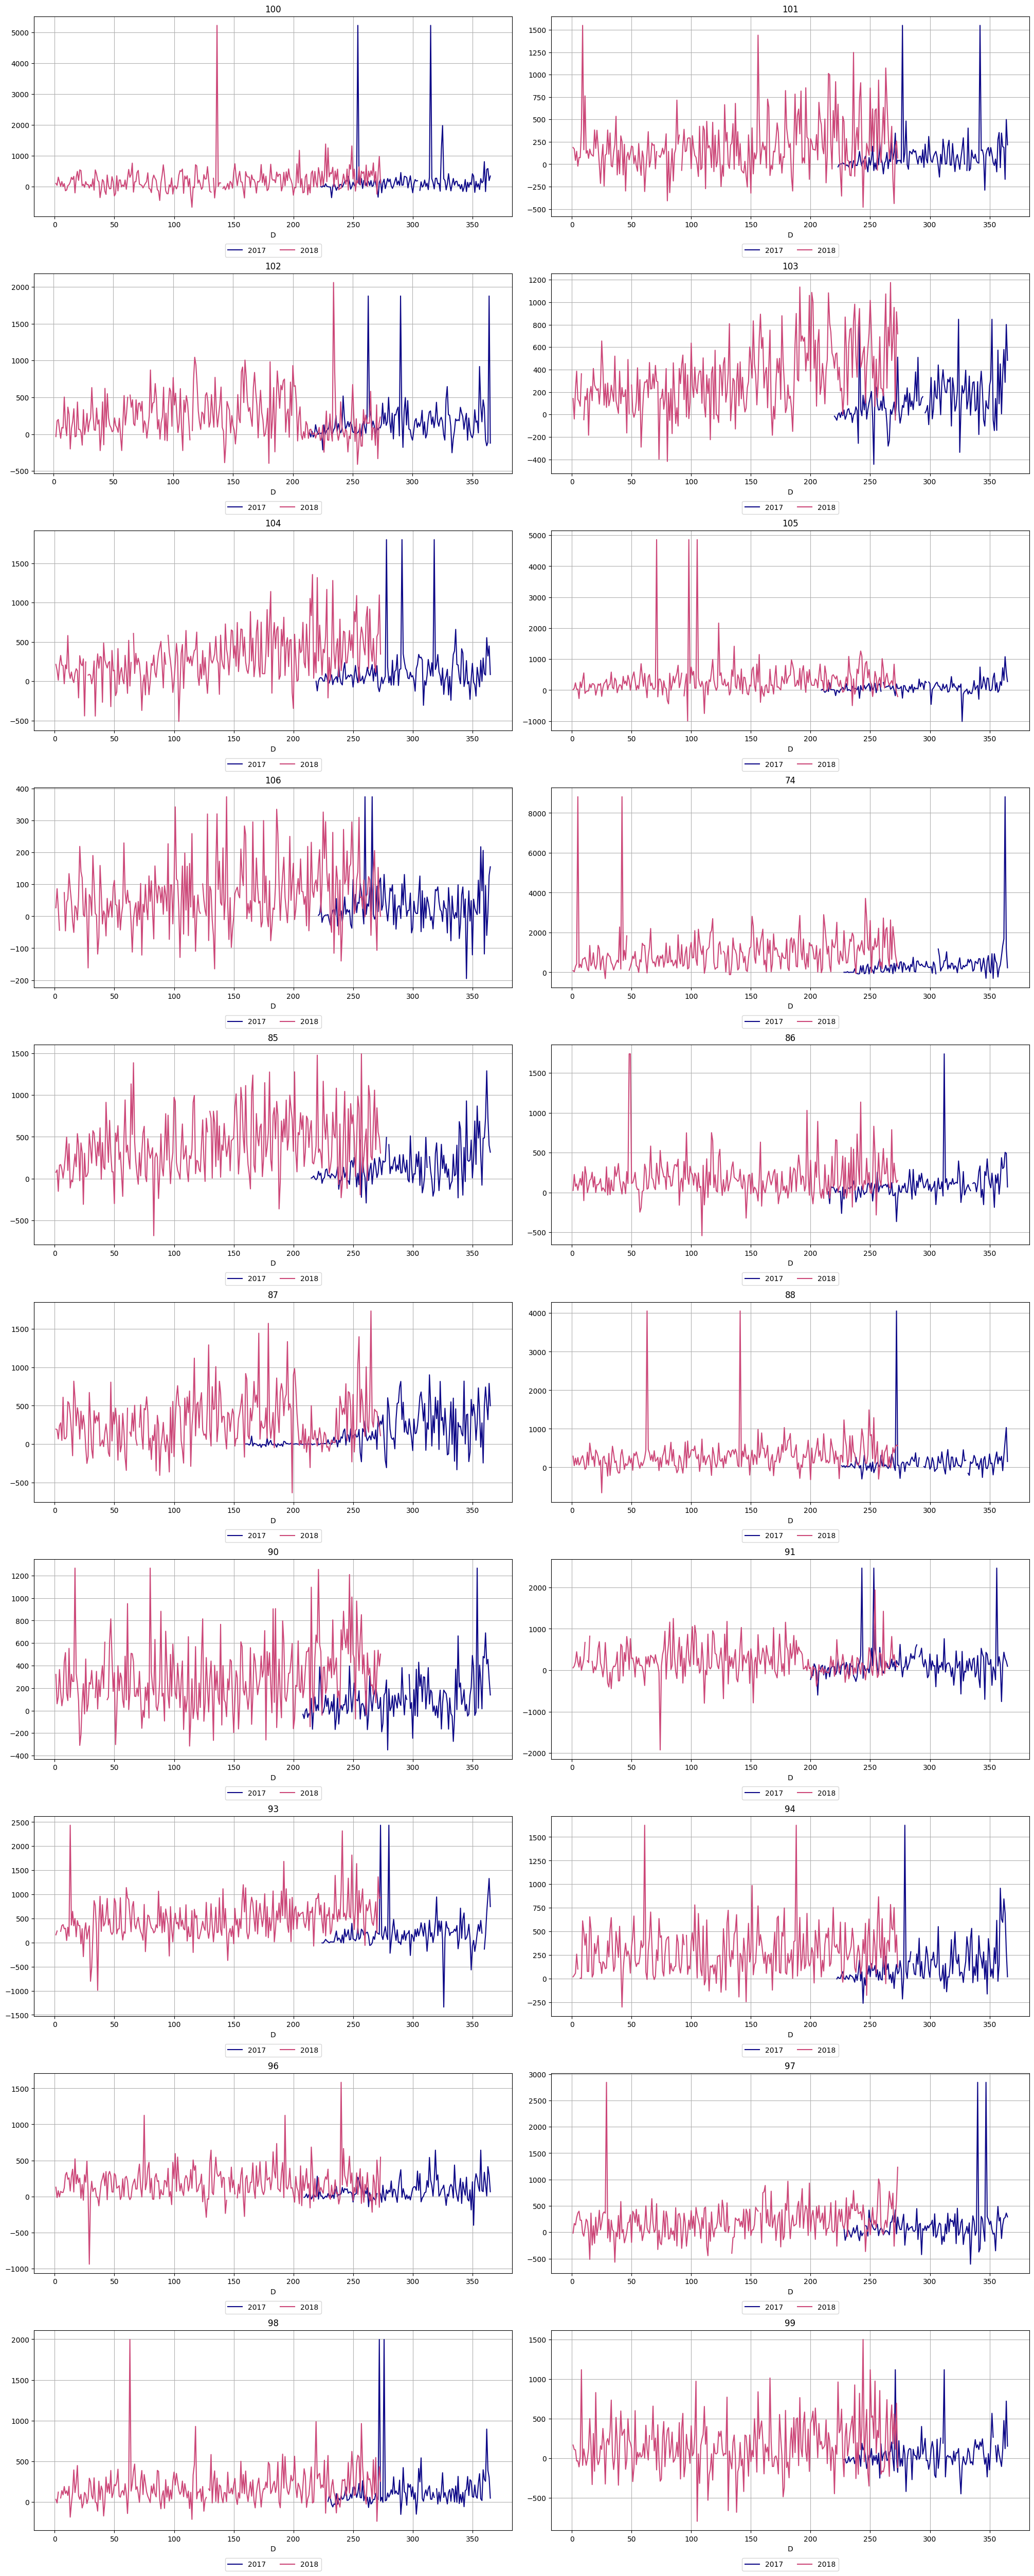

In [ ]:
seasonal_plot(ts=ts, cycle='year')

It's intriguing to note that around the 250th day of the year, there's a notable peak in the amount of cash held in ATMs. This coincides with the month of September, a time when many individuals return from vacations, resume school or work routines, and generally increase their spending, leading to more frequent interactions with ATMs. Additionally, towards the end of the year, we observe another surge in ATM cash levels. This could be attributed to the holiday season, particularly around New Year's, when people often withdraw more cash for various festive expenditures.

This observation seems quite plausible. September marks the end of summer vacations for many, and with the return to routine activities, there's typically an uptick in financial transactions. Similarly, the holiday season towards the end of the year is traditionally associated with increased spending on gifts, travel, and celebrations, which would naturally result in higher ATM usage and cash withdrawals.

**General comments:** we have identified trends and sesonality. It is also visible that there are outliers in the data (which will be addressed in the next portion of the task). There is also no dependence between the time series themselves.

### Задание 2. Работа с пропущенными значениями и выбросами (1 балл)

Проанализируйте, есть ли в данных пропущенные значения, и подберите оптимальный метод их заполнения средствами ETNA. Какие методы вы выберете и почему? Совет: возможно, лучше сохранить заполненные данные в отдельный объект, поскольку некоторые модели заполняют пропуски встроенными методами, и подача на вход "сырых" данных (на языке временных рядов это данные с нерегулярными интервалами) может принести лучший результат.

Импорты всех необходимых компонент произведите самостоятельно.

In [ ]:
#YOUR CODE HERE#

Проверьте ряды на наличие выбросов, и очистите их соответствующим образом. Обоснуйте выбор.

In [ ]:
#YOUR CODE HERE#

### Задание 3. Построение Prophet (1.25 балла)

Постройте прогнозы с помощью Prophet и `etna.Pipeline`, под капотом `etna.Pipeline` обучит `ProphetModel` для каждого сегмента в отдельности. После этого оцените качество по SMAPE на кросс-валидации. В качестве горизонта предсказания возьмите 5 дней - этого же горизонта будем придерживаться и в дальнейшем.

Отрисуйте получившийся прогноз.

In [ ]:
from etna.pipeline import Pipeline
from etna.models import ProphetModel
from etna.metrics import SMAPE, MAE
from etna.analysis import plot_backtest

In [ ]:
HORIZON = 5

In [ ]:
#YOUR CODE HERE#

Исходя из статистики по каждому ряду, какой можно сделать вывод о том, как лучше предсказывать итоговое значение? Посчитайте то же самое исходя из MAE.

In [ ]:
#YOUR CODE HERE#

### Задание 4. Иерархический временной ряд (2 балла)

Вопрос, поставленный в прошлом задании, тем не менее, естественным образом подводит нас к концепции **иерархического временного ряда** (когда один ряд состоит из других в качестве компонент). Это полезная концепция, которая может встретиться во многих задачах. В этом задании вам предстоит самостоятельно разобраться в деталях ее реализации в ETNA с использованием справочных материалов, предоставляемых библиотекой (как это часто бывает на практике). Они содержатся по следующей ссылке:

https://github.com/etna-team/etna/blob/master/examples/303-hierarchical_pipeline.ipynb

На выходе из первой части задания необходимо получить `TSDataset` с иерархической структурой, а также соответствующий реконсилятор, который позволит собирать искомый ряд из составных компонент. Классы, которые вам понадобятся, импортированы ниже.

In [ ]:
from etna.datasets import HierarchicalStructure
from etna.pipeline import HierarchicalPipeline
from etna.reconciliation import TopDownReconciliator

In [ ]:
#YOUR CODE HERE#

Во второй части задания примените найденные на предыдущих этапах преобразования очистку от выбросов уже к иерархическому датасету, и запустите на нем Prophet с MAE на кросс-валидации.

In [ ]:
#YOUR CODE HERE#

### Задание 5. Построение признаков (1.5 балла)

Вернемся к нашему исходному мультисегментному ряду - теперь поработаем с моделями, которые требуют построения признаков - `ARIMA` и `CatBoost`. Построим для них признаки, и попробуем при помощи них добиться улучшения качества.

Из обязательного:
1) постройте графики автокорреляции и при помощи них обоснуйте выбор лаговых признаков
2) для катбуста включите в признаки результаты STL разложения. STL используем для убирания тренда за счет преобразования на месте.
* Кроме этого, подумайте на экспертном уровне,
    - Какие еще закономерности могут присутствовать и почему?
    - Что из этого кажется более предсказуемым, и почему?
    - Cделайте соответствующие признаки, и снабдите их кратким комментарием.

3) После этого, обучите на получившихся признаках модели. Для `CatBoost` рассмотрите 2 версии мультисегментную и на каждый ряд в отдельности.

Ниже приведены импорты, которые вам точно понадобятся - к ним необходимо добавить те инструменты, которые вы дополнительно решите использовать в анализе.

In [ ]:
from etna.analysis import acf_plot, stl_plot
from etna.ensembles import DirectEnsemble, StackingEnsemble, VotingEnsemble
from etna.models import (CatBoostMultiSegmentModel, CatBoostPerSegmentModel,
                         AutoARIMAModel)
from etna.transforms import STLTransform, LagTransform, SegmentEncoderTransform

In [ ]:
#YOUR CODE HERE#

### Задание 6. Стратегии прогнозирования (1.25 балла)

Как нам известно по семинарским занятиям, при построении прогноза на горизонте дальше следующего наблюдения перед нами встает задача определиться со стратегией генерации прогноза. Попробуйте разные стратегии на нашем горизонте из 5 дней (прямая, рекурсивная). Какая стратегия в совокупности с какой моделью дает лучший результат?

Учитывайте особенности, которые некоторые стратегии могут накладывать на признаки (в частности, на лаговые переменные).

При необходимости, в смешанном методе пользуйтесь упрощенной схемой спецификации моделей/преобразований.

In [ ]:
from etna.pipeline import AutoRegressivePipeline, Pipeline, assemble_pipelines
from etna.ensembles import DirectEnsemble

In [ ]:
#YOUR CODE HERE#

### Задание 7. Ансамбли (1.25 балла)

Чтобы не выбирать лучшую модель, мы можем использовать преимущества каждой - давайте объединим все наши наработки в ансамбль. Попробуйте различные опции ансамблирования, и выберите ту, которая работает лучше всего (не забывайте, что внутри каждого ансамбля у нас тоже есть параметры, которые мы можем варьировать - веса в voting, включаемые признаки в stacking).

In [ ]:
from etna.ensembles import StackingEnsemble, VotingEnsemble

In [ ]:
#YOUR CODE HERE#

### Задание 8*. Трансформер (бонус 2 балла)

Для желающих протестировать мощь трансформенных моделей предлагается "завести" модель из второго семинара по временным рядам на текущем датасете. На этот раз абсолютно все необходимые импорты и зависимости подгружаются на ваше усмотрение. Удалось ли вам улучшить качество по сравнению с классическими моделями / моделями на основе ML? Что бы вы предпочли внедрить в production?

*NB:* все, конечно, прекрасно знают механизм работы бонусных заданий, но порядка ряди прописать дисклеймер должны - итоговый балл за домашнее задание ставится по формуле min(10, ваш суммарный балл за задания).

In [ ]:
#YOUR CODE HERE#